# 7-segment displays

This notebook gives a cute example to show off memo's interoperability with the broader JAX ecosystem, which includes deep learning, graphics, physics simulation, and more.

A [seven-segment display](https://en.wikipedia.org/wiki/Seven-segment_display) uses seven lights to display a variety of characters. But when designing a "font" for such a display, [you have to be careful to avoid ambiguities](https://harold.thimbleby.net/cv/files/seven-segment.pdf): for example, a capital "B" and the letter "8" naïvely map to the same pattern (all seven segments on), but are impossible to distinguish. Nonetheless, people have come up with all kinds of [creative variants](https://youtu.be/Th-u84OkpeQ?si=2K01bAX2LjjnXiMJ).

Can we model intuitions about 7-segment displays as a kind of rational communication? To do so, let us start by training a simple neural network model of hand-written character recognition on the EMNIST dataset, using JAX's `flax` ecosystem for deep learning. We will then build a memo model that reasons _over_ this neural network!

We'll start with some imports…

In [354]:
import jax
import jax.numpy as jnp
import numpy as np
import jax.scipy as jsp

import torch
import torchvision.datasets

import math

from matplotlib import pyplot as plt

from memo import memo
import os
# os.environ["ENABLE_PJRT_COMPATIBILITY"] = "1"
jax.default_backend()

'gpu'

Next, we use PyTorch's built-in tools to download and parse the EMNIST dataset.

In [6]:
ds_letter = torchvision.datasets.EMNIST(root='7-aux/data', split='letters', download='True')
ds_number = torchvision.datasets.EMNIST(root='7-aux/data', split='digits', download='True')

17.5%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

45.6%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

73.7%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100.0%


Extracting 7-aux/data/EMNIST/raw/gzip.zip to 7-aux/data/EMNIST/raw


In [8]:
feats = []
labls = []

from collections import Counter
cnt = Counter()
for feat, labl in ds_number:
    if cnt[labl] > 4800:
        continue
    cnt[labl] += 1
    feats.append(np.array(feat).T)
    labls.append(labl)
for feat, labl in ds_letter:
    if 1 <= labl <= 26:
        feats.append(np.array(feat).T)
        labls.append(labl + 10 - 1)

In [9]:
feats_ = np.expand_dims(np.array(feats), -1)
labls_ = np.expand_dims(np.array(labls), -1)
ds = list(zip(feats_, labls_))

In [10]:
import torchvision.transforms.v2 as transforms

transforms = transforms.Compose([
    # transforms.ToPILImage(),
    # transforms.Resize((28, 28)),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.RandomRotation(degrees=10),
    transforms.ToDtype(torch.float32, scale=True),
])

Next, we train a tiny neural network on this dataset. (Or, we load saved weights from a file if a checkpoint exists.)

In [52]:
from functools import partial
from typing import Any
from collections.abc import Callable, Sequence

from flax import linen as nn
from flax.training import train_state
import optax

import orbax.checkpoint
from flax.training import orbax_utils
import os.path

NUM_CLASS = 36
# initializer = nn.initializers.xavier_uniform()

class CNN(nn.Module):
    @nn.compact
    def __call__(self, x, train=False):
        x = x / 255
        x = nn.Conv(features=40, kernel_size=(5, 5))(x)
        x = nn.leaky_relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(1, 1))
        x = nn.Conv(features=160, kernel_size=(5, 5))(x)
        x = nn.leaky_relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(1, 1))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=200)(x)
        x = nn.leaky_relu(x)
        x = nn.Dropout(rate=0.4, deterministic=not train)(x)
        return nn.Dense(features=NUM_CLASS)(x)

class MLP(nn.Module):
    @nn.compact
    def __call__(self, x, train=False):
        x = x / 255
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=NUM_CLASS)(x)
        return x

ModuleDef = Any


class ResNetBlock(nn.Module):
  """ResNet block."""

  filters: int
  conv: ModuleDef
  norm: ModuleDef
  act: Callable
  strides: tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(
      self,
      x,
  ):
    residual = x
    y = self.conv(self.filters, (3, 3), self.strides)(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3), kernel_init=initializer)(y)
    y = self.norm(scale_init=nn.initializers.zeros_init())(y)

    if residual.shape != y.shape:
      residual = self.conv(
          self.filters, (1, 1), self.strides, name='conv_proj'
      )(residual)
      residual = self.norm(name='norm_proj')(residual)

    return self.act(residual + y)


class BottleneckResNetBlock(nn.Module):
  """Bottleneck ResNet block."""

  filters: int
  conv: ModuleDef
  norm: ModuleDef
  act: Callable
  strides: tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(self, x):
    residual = x
    y = self.conv(self.filters, (1, 1))(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3), self.strides)(y)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters * 4, (1, 1))(y)
    y = self.norm(scale_init=nn.initializers.zeros_init())(y)

    if residual.shape != y.shape:
      residual = self.conv(
          self.filters * 4, (1, 1), self.strides, name='conv_proj'
      )(residual)
      residual = self.norm(name='norm_proj')(residual)

    return self.act(residual + y)


class ResNet(nn.Module):
  """ResNetV1.5."""

  stage_sizes: Sequence[int]
  block_cls: ModuleDef
  num_classes: int
  num_filters: int = 64
  dtype: Any = jnp.float32
  act: Callable = nn.relu
  conv: ModuleDef = nn.Conv

  @nn.compact
  def __call__(self, x, train: bool = True):
    conv = partial(self.conv, use_bias=False, dtype=self.dtype)
    # norm = partial(
    #     nn.BatchNorm,
    #     use_running_average=not train,
    #     momentum=0.9,
    #     epsilon=1e-5,
    #     dtype=self.dtype,
    #     # axis_name='batch',
    # )
    norm = partial(nn.LayerNorm, epsilon=1e-5, dtype=self.dtype)

    x = conv(
        self.num_filters,
        (7, 7),
        (2, 2),
        padding=[(3, 3), (3, 3)],
        name='conv_init',
    )(x)
    x = norm(name='bn_init')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, (3, 3), strides=(2, 2), padding='SAME')
    for i, block_size in enumerate(self.stage_sizes):
      for j in range(block_size):
        strides = (2, 2) if i > 0 and j == 0 else (1, 1)
        x = self.block_cls(
            self.num_filters * 2**i,
            strides=strides,
            conv=conv,
            norm=norm,
            act=self.act,
        )(x)
    x = jnp.mean(x, axis=(1, 2))
    x = nn.Dense(self.num_classes, dtype=self.dtype)(x)
    x = jnp.asarray(x, self.dtype)
    return x


model = "resnet"
ResNet18 = partial(ResNet, stage_sizes=[2, 2, 2, 2], block_cls=ResNetBlock)
if model == "resnet":
  cnn = ResNet18(num_classes=NUM_CLASS)
elif model == "cnn":
  cnn = CNN()
elif model == "mlp":
    cnn = MLP()
else:
    raise Exception()

In [53]:
@jax.jit
def apply_model(state, images, labels):
    # print(images.shape, labels.shape)
    key = jax.random.fold_in(state.rng, state.step)

    def loss_fn(params):
        logits = state.apply_fn({'params': params}, images, train=True, rngs={"dropout": key})
        one_hot = jax.nn.one_hot(labels, NUM_CLASS)[:, 0, :]
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels[:, 0])
    # print((jnp.argmax(logits, -1) == labels[:, 0]).shape)
    return grads, loss, accuracy


@jax.jit
def update_model(state, grads):
    state = state.apply_gradients(grads=grads)
    return state


def schedule(base_lr, steps_per_epoch):
    epochs = 60
    warmup_epochs = 5
    warmup = optax.linear_schedule(
      init_value=0., end_value=base_lr,
      transition_steps=5 * steps_per_epoch)
    cosine_epochs = epochs - warmup_epochs
    cosine = optax.cosine_decay_schedule(
        init_value=base_lr,
        decay_steps=cosine_epochs * steps_per_epoch)
    schedule_fn = optax.join_schedules(
        schedules=[warmup, cosine],
        boundaries=[5 * steps_per_epoch])
    return schedule_fn

class TrainState(train_state.TrainState):
    rng: jax.random.PRNGKey

rng = jax.random.key(0)
rng, param_key, dropout_key = jax.random.split(rng, num=3)
variables = cnn.init(param_key, jnp.empty([1, 28, 28, 1]), train=False)
params = variables['params']
# tx = optax.adam(0.003)
scheduler = schedule(0.001, math.ceil(feats_.shape[0] / 128))
tx = optax.adamw(scheduler, weight_decay=0.01)

In [54]:
import re

# state = TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)
retrain = False
checks = [f for f in os.listdir("/om/user/chent777/7-aux") if f.startswith(model + "weights")]
if len(checks) > 0:
    restore = sorted(checks, key=lambda x: int(re.match(rf'{model}weights(\d+)', x).group(1)))[-1]

if not retrain:
    target = jax.tree_util.tree_map(np.zeros_like, variables['params'])
    params = orbax.checkpoint.StandardCheckpointer().restore(f"/om/user/chent777/7-aux/{restore}", target)
    state = TrainState.create(apply_fn=cnn.apply, params=params, tx=tx, rng=dropout_key)
else:
    state = TrainState.create(apply_fn=cnn.apply, params=params, tx=tx, rng=dropout_key)
    losses = []
    accs = []
    lrs = []
    for epoch in range(60):
        print(epoch)
        from torch.utils.data import DataLoader
        dl = DataLoader(ds, batch_size=128, shuffle=True)
        for t, (feat, labl) in enumerate((dl)):
            feat = transforms(feat.permute(0, 3, 1, 2))
            feat = jnp.array(feat).transpose(0, 2, 3, 1)
            labl = jnp.array(labl)
            grads, loss, accuracy = apply_model(state, feat, labl)
            state = update_model(state, grads)
            if t % 400 == 0:
                losses.append(loss)
                accs.append(accuracy)
                lrs.append(scheduler(state.step).item())
        print(epoch, losses[-1], accs[-1])

        if epoch % 5 == 0:
            # ckpt = {'state': state}
            ckpt = state.params
            checkpointer = orbax.checkpoint.StandardCheckpointer()
            save_args = orbax_utils.save_args_from_target(ckpt)
            # save_args = orbax.checkpoint.args.StandardSave(state)
            checkpointer.save(f'/om/user/chent777/7-aux/{model}weights{epoch}', ckpt, save_args=save_args, force=True)

    plt.plot(accs)
    plt.ylabel('Accuracy')
    plt.xlabel('Time')

Now, let's feed our trained neural network some 7-segment displays and see how it does. We can generate 7-segment displays in JAX by performing simple pixel manipulations on an array.

Do the neural network's guesses match your intuitions?

In [424]:
U_reduced = jnp.array([27, 40, 42, 43, 44, 45, 46, 47, 53, 55, 57, 59, 61, 62, 63, 79, 80, 81, 84, 87, 89, 90, 91, 94, 95, 102, 106, 109, 110, 111, 116, 117, 118, 119, 121, 122, 123, 124, 125, 127])


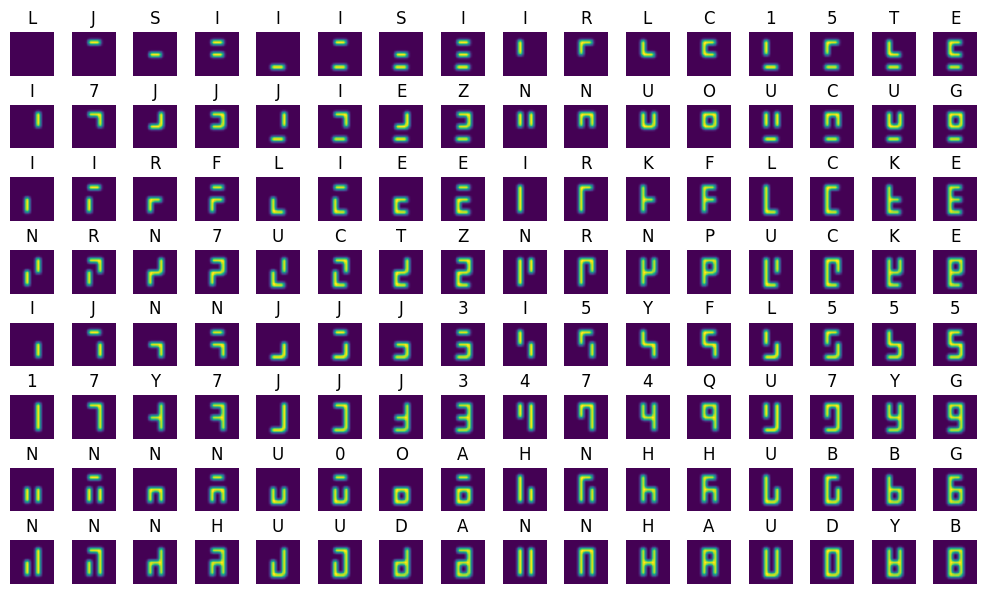

In [425]:
mask = jnp.zeros(36)
# mask = mask.at[16:].set(-99999999)


@jax.jit
def predict(state, img):
    # return (
    #     state.apply_fn(
    #         {"params": state.params},
    #         jnp.expand_dims(img, (0, -1)),
    #         train=False
    #     )[0]
    #     + mask
    # )
    out = (state.apply_fn({"params": state.params}, jnp.expand_dims(img, (0, -1)), train=False)[0] + mask)
    sorted_values = out.argsort()
    # return out.at[sorted_values[:-3]].set(-20)
    return out


@jax.jit
def make_7seg(i):
    L = +9
    R = -11
    U = 4
    M = 13
    D = 22
    canvas = jnp.zeros((28, 28))
    segs = [(i & (1 << n)) != 0 for n in range(7)]
    canvas = canvas.at[U, L:R].set(segs[0])
    canvas = canvas.at[M, L:R].set(segs[1])
    canvas = canvas.at[D, L:R].set(segs[2])
    canvas = canvas.at[U : M, L].set(segs[3])
    canvas = canvas.at[U : M, R].set(segs[4])
    # canvas = canvas.at[M + 1 : D, L - 1].set(segs[5])
    # canvas = canvas.at[M + 1 : D, R].set(segs[6])
    canvas = canvas.at[M : D, L].set(segs[5])
    canvas = canvas.at[M : D, R].set(segs[6])
    canvas = (
        canvas
        + jnp.roll(canvas, 1, axis=0)
        + jnp.roll(canvas, 1, axis=1)
        + jnp.roll(canvas, 2, axis=0)
        + jnp.roll(canvas, 2, axis=1)
        + jnp.roll(jnp.roll(canvas, 1, axis=0), 1, axis=1)
        + jnp.roll(jnp.roll(canvas, 2, axis=0), 2, axis=1)
    )
    canvas = 255 * (canvas != 0)
    canvas = jsp.signal.convolve2d(canvas, jnp.array([[1., 2., 1.], [2., 4., 2.], [1., 2., 1.]]))
    canvas = jsp.signal.convolve2d(canvas, jnp.array([[1., 2., 1.], [2., 4., 2.], [1., 2., 1.]]))


    return canvas


plt.figure(figsize=(10, 6))
for i in range(128):
    plt.subplot(8, 16, i + 1)
    img = np.array(make_7seg(i))
    plt.imshow(img)
    import string

    chars = string.digits + string.ascii_uppercase
    name = (
        chars[predict(state, img).argsort()[-1]]
        # + ', ' +
        # chars[predict(img).argsort()[-2]]
    )
    plt.title(name)
    plt.axis("off")
plt.tight_layout()

In [426]:
from memo import memo

U = jnp.arange(128)
U = U_reduced
R = jnp.arange(36)
R_display = jnp.array([0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 21, 24, 25, 26, 34, 35])
R_display = R
R = R_display

@jax.jit
def pretrained_classifier(u, r):
    return predict(state, make_7seg(u))[r]

@jax.jit
def num_segments(u):
    shifts = u & (1 << jnp.arange(7))
    return jnp.count_nonzero(shifts)
    # return jnp.sum((u & (1 << n)) != 0 for n in range(7))

@memo
def literal_speaker[u: U, r: R](beta):
    cast: [speaker]
    speaker: knows(r)
    speaker: chooses(u in U, wpp=exp(beta * pretrained_classifier(u, r)))
    return E[speaker.u == u]

@memo
def speaker[u: U, r: R](beta, t):
    cast: [speaker, listener]
    speaker: knows(r)
    speaker: chooses(u in U, wpp=exp(beta * pretrained_classifier(u, r)) if t == 0 else exp(beta * listener[u, r](beta, t)))
    return E[speaker.u == u]

@memo
def listener[u: U, r: R](beta, t):
    cast: [listener, speaker]
    listener: thinks[
        speaker: given(r in R, wpp=1),
        speaker: chooses(
            u in U,
            wpp=speaker[u, r](beta, t - 1),
        )
    ]
    listener: observes [speaker.u] is u
    listener: chooses(r in R, wpp=E[speaker.r == r])
    return E[listener.r == r]
    # return exp(beta * E[listener.r == r])

Now, we can see how the emergent convention / "font" changes as we add more levels of recursive reasoning.

CPU times: user 3.61 s, sys: 34.5 ms, total: 3.65 s
Wall time: 3.45 s


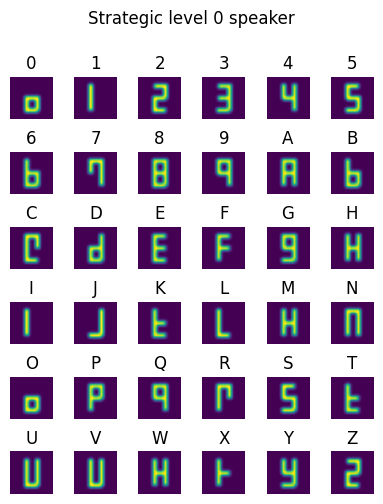

CPU times: user 139 ms, sys: 2.02 ms, total: 141 ms
Wall time: 180 ms


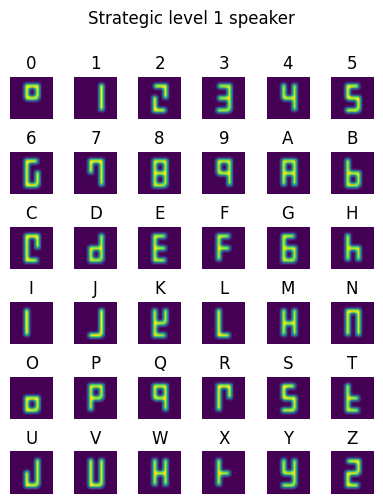

CPU times: user 5.22 ms, sys: 12 μs, total: 5.23 ms
Wall time: 3.99 ms


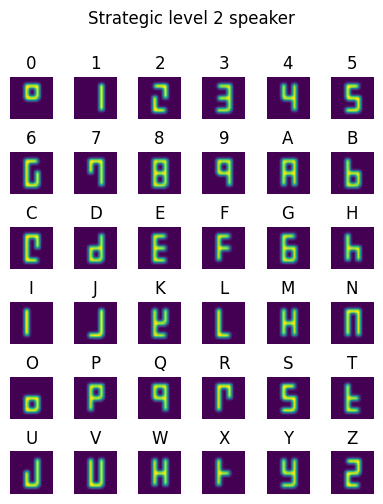

CPU times: user 6.66 ms, sys: 0 ns, total: 6.66 ms
Wall time: 5.4 ms


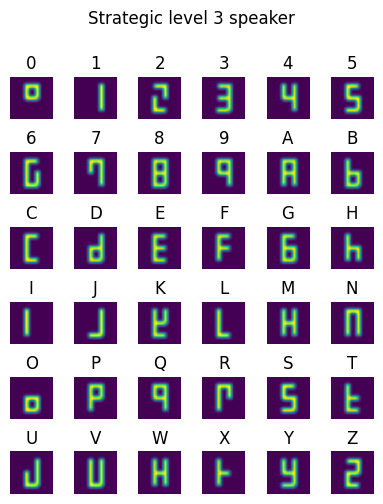

In [427]:
for t in range(4):
    # plt.figure(figsize=(4, 16))
    plt.figure(figsize=(4, 5))
    plt.gcf().subplots_adjust(top=0.8)
    %time S = speaker(2.0, t)
    plt.suptitle(f'Strategic level {t} speaker', y=1.0)
    for i in range(len(R_display)):
        plt.subplot(6, 6, i+1)
        plt.imshow(make_7seg(U_reduced[jnp.argmax(S[:, i])]))
        plt.title(chars[R_display[i]])
        plt.axis("off")
    # for i in range(16):
    #     # plt.subplot(6, 6, i + 1)
    #     for j, disp in enumerate(reversed(jnp.argsort(S[:, i])[-3:])):
    #         plt.subplot(16, 3, i*3 + j + 1)
    #         plt.imshow(make_7seg(disp))
    #         if j == 0:
    #             plt.title(chars[i], x=-0.2, y=0.4)
    #     # plt.imshow(make_7seg(jnp.argmax(S[:, i])))
    #         plt.axis('off')
    #     plt.axis("off")
    plt.tight_layout()
    plt.show()

In [347]:
U_reduced

Array([ 27,  40,  43,  44,  45,  47,  53,  55,  57,  59,  61,  63,  79,
        80,  81,  84,  87,  89,  90,  91,  94,  95, 102, 106, 107, 109,
       110, 111, 116, 117, 118, 119, 122, 123, 124, 125, 127],      dtype=int32)

In [181]:
U_reduced

Array([ 27,  43,  44,  45,  46,  47,  51,  55,  57,  59,  61,  63,  75,
        79,  81,  84,  87,  89,  90,  91,  94,  95, 102, 106, 107, 109,
       110, 111, 116, 117, 118, 119, 122, 123, 124, 125, 127],      dtype=int32)

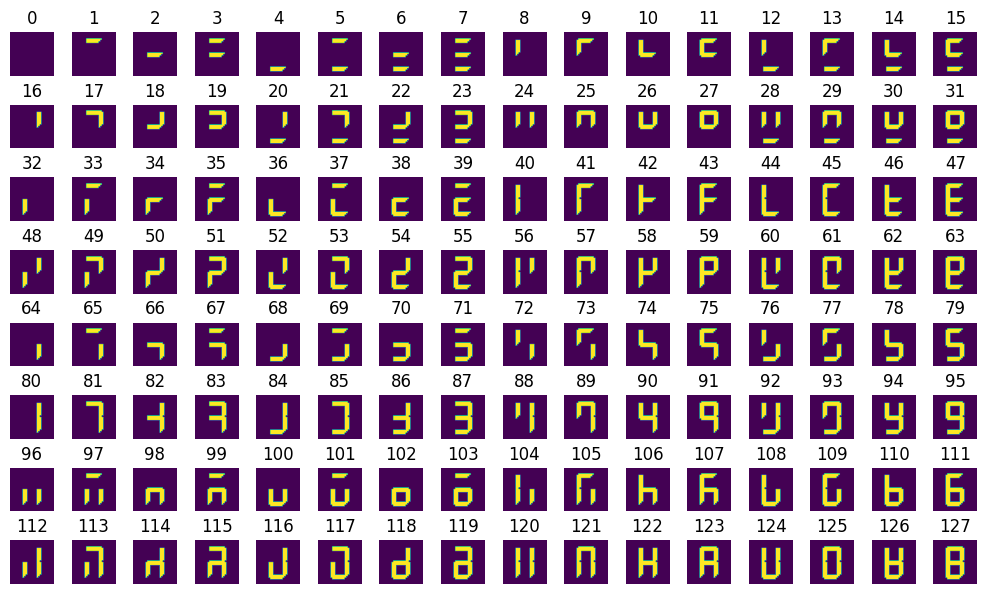

In [292]:
plt.figure(figsize=(10, 6))
for i in range(128):
    plt.subplot(8, 16, i + 1)
    img = np.array(make_7seg(i))
    plt.imshow(img)
    import string
    plt.title(i)
    plt.axis("off")
plt.tight_layout()

[(-0.15750277042388916, '0'), (-20.0, '1'), (-20.0, '2'), (-20.0, '3'), (-20.0, '4'), (-20.0, '5'), (-20.0, '6'), (-20.0, '7'), (-20.0, '8'), (-20.0, '9'), (-20.0, 'A'), (-20.0, 'B'), (-20.0, 'C'), (-20.0, 'D'), (-20.0, 'E'), (-20.0, 'F'), (-20.0, 'G'), (-20.0, 'H'), (-20.0, 'I'), (-20.0, 'J'), (-20.0, 'K'), (-20.0, 'L'), (-20.0, 'M'), (-20.0, 'N'), (0.16036581993103027, 'O'), (-20.0, 'P'), (-20.0, 'Q'), (-20.0, 'R'), (-20.0, 'S'), (-20.0, 'T'), (-4.79230260848999, 'U'), (-20.0, 'V'), (-20.0, 'W'), (-20.0, 'X'), (-20.0, 'Y'), (-20.0, 'Z')]


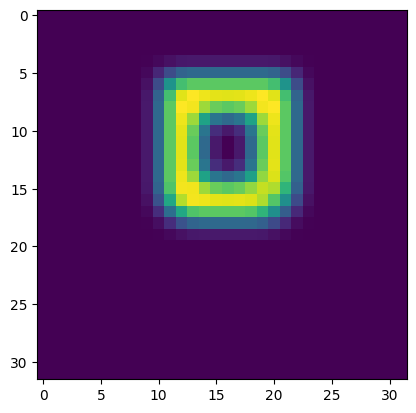

In [382]:
idx = 27
plt.imshow(make_7seg(idx))
p = predict(state, make_7seg(idx))
# p[p.argsort()[::-1]]
print(list(zip(p.tolist(), chars)))

In [423]:
target = 29
best = sorted([(predict(state, make_7seg(i))[target], i) for i in range(128)], key=lambda x: x[0], reverse=True)
best

[(Array(0.44908026, dtype=float32), 54),
 (Array(0.39490715, dtype=float32), 46),
 (Array(-1.4995617, dtype=float32), 82),
 (Array(-2.694759, dtype=float32), 14),
 (Array(-2.7517285, dtype=float32), 22),
 (Array(-3.6279569, dtype=float32), 17),
 (Array(-3.6427126, dtype=float32), 78),
 (Array(-3.8578477, dtype=float32), 37),
 (Array(-3.91673, dtype=float32), 1),
 (Array(-3.92272, dtype=float32), 94),
 (Array(-3.955019, dtype=float32), 62),
 (Array(-4.099783, dtype=float32), 106),
 (Array(-4.1100726, dtype=float32), 42),
 (Array(-4.371016, dtype=float32), 49),
 (Array(-4.4050303, dtype=float32), 33),
 (Array(-4.937722, dtype=float32), 50),
 (Array(-5.22743, dtype=float32), 77),
 (Array(-5.2317305, dtype=float32), 41),
 (Array(-5.3729186, dtype=float32), 114),
 (Array(-5.5018444, dtype=float32), 65),
 (Array(-5.531947, dtype=float32), 34),
 (Array(-5.8305554, dtype=float32), 79),
 (Array(-5.851282, dtype=float32), 66),
 (Array(-5.9309664, dtype=float32), 74),
 (Array(-5.941842, dtype=flo

Finally, let's build an RSA model where the literal listener is modeled as running our neural network on the input image ("utterance") and taking the logits as the log-posterior. Notice that the utterance space is 128, i.e. $2^7$ configurations of the seven-segment display, and the referent space is 36, i.e. 10 digits + 26 letters.

In [421]:
chars.index("T")

29

In [162]:
jnp.argsort(S[:, 0])

Array([  0,   1,   2,   4,   8,  16,  32,  64,   3,   5,   6,   9,  10,
        12,  17,  20,  24,  33,  34,  36,  40,  48,  65,  66,  72,  80,
        18,  68,  96,   7,  11,  13,  14,  19,  21,  22,  28,  35,  37,
        38,  41,  42,  44,  49,  50,  52,  56,  67,  69,  70,  73,  74,
        76,  81,  82,  88,  97, 104,  84,  25,  98, 112,  26,  15,  23,
        39,  43,  45,  46,  51,  53,  54,  58,  60,  71,  75,  77,  78,
        83,  85,  86,  89,  90,  99, 105, 106, 108, 113, 114,  30,  92,
        57, 120,  29, 101,  27, 116,  47,  55,  59,  62,  79,  87,  91,
        93,  94, 107, 109, 110, 115, 117, 118, 122,  31, 124,  61, 103,
        63,  95, 111, 119, 123, 126, 125, 121, 127, 100, 102],      dtype=int32)

In [162]:
jnp.argsort(S[:, 0])

Array([  0,   1,   2,   4,   8,  16,  32,  64,   3,   5,   6,   9,  10,
        12,  17,  20,  24,  33,  34,  36,  40,  48,  65,  66,  72,  80,
        18,  68,  96,   7,  11,  13,  14,  19,  21,  22,  28,  35,  37,
        38,  41,  42,  44,  49,  50,  52,  56,  67,  69,  70,  73,  74,
        76,  81,  82,  88,  97, 104,  84,  25,  98, 112,  26,  15,  23,
        39,  43,  45,  46,  51,  53,  54,  58,  60,  71,  75,  77,  78,
        83,  85,  86,  89,  90,  99, 105, 106, 108, 113, 114,  30,  92,
        57, 120,  29, 101,  27, 116,  47,  55,  59,  62,  79,  87,  91,
        93,  94, 107, 109, 110, 115, 117, 118, 122,  31, 124,  61, 103,
        63,  95, 111, 119, 123, 126, 125, 121, 127, 100, 102],      dtype=int32)

In [162]:
jnp.argsort(S[:, 0])

Array([  0,   1,   2,   4,   8,  16,  32,  64,   3,   5,   6,   9,  10,
        12,  17,  20,  24,  33,  34,  36,  40,  48,  65,  66,  72,  80,
        18,  68,  96,   7,  11,  13,  14,  19,  21,  22,  28,  35,  37,
        38,  41,  42,  44,  49,  50,  52,  56,  67,  69,  70,  73,  74,
        76,  81,  82,  88,  97, 104,  84,  25,  98, 112,  26,  15,  23,
        39,  43,  45,  46,  51,  53,  54,  58,  60,  71,  75,  77,  78,
        83,  85,  86,  89,  90,  99, 105, 106, 108, 113, 114,  30,  92,
        57, 120,  29, 101,  27, 116,  47,  55,  59,  62,  79,  87,  91,
        93,  94, 107, 109, 110, 115, 117, 118, 122,  31, 124,  61, 103,
        63,  95, 111, 119, 123, 126, 125, 121, 127, 100, 102],      dtype=int32)

In [65]:
list(reversed(jnp.argsort(S[:, 0])[-3:]))

[Array(27, dtype=int32), Array(125, dtype=int32), Array(102, dtype=int32)]

This demo isn't perfect, but you can see that the strategic speakers are "trying" to minimize ambiguity, and often come up with some pretty "clever" solutions as well (I particularly like the "V").

By the way, notice the timestamps: memo evaluations are just milliseconds.